In [1]:
import pandas as pd
df=pd.read_csv("preprocessed_dataset.csv")

In [2]:
import numpy as np
import statsmodels.formula.api as smf

# treatment already coded: 1 = (Buy One Get One OR Discount), 0 = No Offer
y = df['conversion']  # outcome
t = df['treatment']   # exposure


In [3]:
#Function to compute four-cell risks
def four_cell_risks(df, y, t, b):
    # ensure column exists
    if b not in df.columns:
        raise KeyError(f"{b} not found in dataframe")

    # group by treatment and modifier
    g = df.groupby([t, b])[y].agg(['mean','size']).rename(
        columns={'mean':'risk','size':'n'}
    ).reset_index()

    # dictionary of observed risks and counts
    cells = {(row[t], row[b]): (row['risk'], row['n']) for _, row in g.iterrows()}

    # helper to safely extract risks and counts
    def get_val(i, j, idx):
        return cells.get((i, j), (np.nan, 0))[idx]

    return {
        'R00': get_val(0,0,0), 'R10': get_val(1,0,0),
        'R01': get_val(0,1,0), 'R11': get_val(1,1,0),
        'N00': get_val(0,0,1), 'N10': get_val(1,0,1),
        'N01': get_val(0,1,1), 'N11': get_val(1,1,1)
    }



In [4]:
#Additive Interaction (AERI)
def aeri_from_risks(R):
    return R['R11'] + R['R00'] - R['R10'] - R['R01']


In [5]:
#Logistic regression with interaction term (Multiplicative)
def fit_interaction_logit(df, y, t, b, adjust=None):
    adjust = adjust or []
    rhs = [t, b, f"{t}:{b}"] + adjust
    formula = f"{y} ~ " + " + ".join(rhs)
    return smf.logit(formula, data=df).fit(disp=0)


In [6]:
#RERI and Modified AP (Additive on ratio scale)
def reri_from_logit(model, t, b):
    params = model.params
    OR_T    = np.exp(params.get(t, 0.0))
    OR_B    = np.exp(params.get(b, 0.0))
    OR_TxB  = np.exp(params.get(f"{t}:{b}", 0.0))
    OR_11   = OR_T * OR_B * OR_TxB
    RERI    = OR_11 - OR_T - OR_B + 1
    modified_AP = np.nan if OR_11==1 else RERI / (OR_11 - 1)
    return dict(OR_T=OR_T, OR_B=OR_B, OR_TxB=OR_TxB, OR_11=OR_11,
                RERI=RERI, modified_AP=modified_AP)


In [7]:
R = four_cell_risks(df, y, t, 'used_discount')
print(R)


KeyError: 'Columns not found: 0, 1'

In [8]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# -------------------------------
# STEP 1: Variables
# -------------------------------
y = 'conversion'   # outcome
t = 'treatment'    # exposure

# Candidate binary effect modifiers
candidate_modifiers = [
    'used_discount','used_bogo','is_referral',
    'channel_Phone','channel_Web',
    'zip_code_Urban','zip_code_Surburban'
]

# Keep only those actually in dataframe
binary_modifiers = [col for col in candidate_modifiers if col in df.columns]

print("Binary modifiers being tested:", binary_modifiers)


# -------------------------------
# STEP 2: Functions
# -------------------------------
def four_cell_risks(df, y, t, b):
    """Compute subgroup risks and counts for treatment × modifier cells."""
    g = df.groupby([t, b])[y].agg(['mean','size']).rename(
        columns={'mean':'risk','size':'n'}
    ).reset_index()

    # dictionary of observed risks and counts
    cells = {(row[t], row[b]): (row['risk'], row['n']) for _, row in g.iterrows()}

    # helper to safely extract risks and counts
    def get_val(i, j, idx):
        return cells.get((i, j), (np.nan, 0))[idx]

    return {
        'R00': get_val(0,0,0), 'R10': get_val(1,0,0),
        'R01': get_val(0,1,0), 'R11': get_val(1,1,0),
        'N00': get_val(0,0,1), 'N10': get_val(1,0,1),
        'N01': get_val(0,1,1), 'N11': get_val(1,1,1)
    }


def aeri_from_risks(R):
    """Absolute Excess Risk due to Interaction"""
    return R['R11'] + R['R00'] - R['R10'] - R['R01']


def fit_interaction_logit(df, y, t, b, adjust=None):
    """Fit logistic regression with interaction term"""
    adjust = adjust or []
    rhs = [t, b, f"{t}:{b}"] + adjust
    formula = f"{y} ~ " + " + ".join(rhs)
    return smf.logit(formula, data=df).fit(disp=0)


def reri_from_logit(model, t, b):
    """Compute RERI and Modified AP from logistic regression"""
    params = model.params
    OR_T    = np.exp(params.get(t, 0.0))
    OR_B    = np.exp(params.get(b, 0.0))
    OR_TxB  = np.exp(params.get(f"{t}:{b}", 0.0))
    OR_11   = OR_T * OR_B * OR_TxB
    RERI    = OR_11 - OR_T - OR_B + 1
    modified_AP = np.nan if OR_11==1 else RERI / (OR_11 - 1)
    return dict(OR_T=OR_T, OR_B=OR_B, OR_TxB=OR_TxB,
                OR_11=OR_11, RERI=RERI, modified_AP=modified_AP)


# -------------------------------
# STEP 3: Loop over modifiers
# -------------------------------
results = []

for b in binary_modifiers:
    try:
        # 1. Four-cell risks and AERI
        R = four_cell_risks(df, y, t, b)
        AERI = aeri_from_risks(R)

        # 2. Logistic regression with interaction
        m = fit_interaction_logit(df, y, t, b)

        # 3. RERI and modified AP
        add = reri_from_logit(m, t, b)

        results.append({
            'modifier': b,
            'N00': R['N00'],'N10': R['N10'],'N01': R['N01'],'N11': R['N11'],
            'R00': R['R00'],'R10': R['R10'],'R01': R['R01'],'R11': R['R11'],
            'AERI': AERI,
            'OR_TxB': add['OR_TxB'],
            'RERI': add['RERI'],
            'modified_AP': add['modified_AP'],
            'p_interaction': m.pvalues.get(f"{t}:{b}", np.nan)
        })
    except Exception as e:
        print(f"Skipping {b} due to error: {e}")

# -------------------------------
# STEP 4: Show results
# -------------------------------
summary = pd.DataFrame(results).round(3)
print(summary)


Binary modifiers being tested: ['used_discount', 'used_bogo', 'is_referral', 'channel_Phone', 'channel_Web', 'zip_code_Urban', 'zip_code_Surburban']
             modifier      N00      N10      N01      N11    R00    R10  \
0       used_discount   8437.0  17028.0  10635.0  21297.0  0.103  0.176   
1           used_bogo   8486.0  16998.0  10586.0  21327.0  0.109  0.150   
2         is_referral   9513.0  19057.0   9559.0  19268.0  0.143  0.201   
3       channel_Phone  10862.0  21785.0   8210.0  16540.0  0.129  0.191   
4         channel_Web  10814.0  21696.0   8258.0  16629.0  0.104  0.166   
5      zip_code_Urban  11470.0  22951.0   7602.0  15374.0  0.121  0.182   
6  zip_code_Surburban  10503.0  21262.0   8569.0  17063.0  0.121  0.182   

     R01    R11   AERI  OR_TxB   RERI  modified_AP  p_interaction  
0  0.124  0.177 -0.020   0.818 -0.221       -0.256          0.000  
1  0.119  0.198  0.039   1.275  0.477        0.472          0.000  
2  0.086  0.152  0.008   1.261  0.001        0

In [ ]:
display(summary)

,modifier,N00,N10,N01,N11,R00,R10,R01,R11,AERI,OR_TxB,RERI,modified_AP,p_interaction
0,used_discount,8437.0,17028.0,10635.0,21297.0,0.103,0.176,0.124,0.177,-0.020,0.818,-0.221,-0.256,0.000
1,used_bogo,8486.0,16998.0,10586.0,21327.0,0.109,0.150,0.119,0.198,0.039,1.275,0.477,0.472,0.000
2,is_referral,9513.0,19057.0,9559.0,19268.0,0.143,0.201,0.086,0.152,0.008,1.261,0.001,0.017,0.000
3,channel_Phone,10862.0,21785.0,8210.0,16540.0,0.129,0.191,0.096,0.158,-0.001,1.097,-0.055,-0.207,0.090
4,channel_Web,10814.0,21696.0,8258.0,16629.0,0.104,0.166,0.129,0.190,-0.000,0.929,0.038,0.038,0.162
5,zip_code_Urban,11470.0,22951.0,7602.0,15374.0,0.121,0.182,0.105,0.169,0.003,1.072,0.010,0.021,0.199
6,zip_code_Surburban,10503.0,21262.0,8569.0,17063.0,0.121,0.182,0.107,0.169,0.002,1.056,-0.005,-0.010,0.310


In [15]:
styled = (
    summary.style
    .set_table_styles(
        [
            # Column headers
            {"selector": "th.col_heading",
             "props": [("background-color", "#4472C4"),
                       ("color", "white"),
                       ("font-weight", "bold"),
                       ("text-align", "center")]},

            # Row index (row labels)
            {"selector": "th.row_heading",
             "props": [("background-color", "#4472C4"),
                       ("color", "white"),
                       ("font-weight", "bold"),
                       ("text-align", "center")]}
        ]
    )
    .set_properties(**{
        "border": "1px solid black",
        "text-align": "center"
    })
)
styled


,modifier,N00,N10,N01,N11,R00,R10,R01,R11,AERI,OR_TxB,RERI,modified_AP,p_interaction
0,used_discount,8437.000000,17028.000000,10635.000000,21297.000000,0.103000,0.176000,0.124000,0.177000,-0.020000,0.818000,-0.221000,-0.256000,0.000000
1,used_bogo,8486.000000,16998.000000,10586.000000,21327.000000,0.109000,0.150000,0.119000,0.198000,0.039000,1.275000,0.477000,0.472000,0.000000
2,is_referral,9513.000000,19057.000000,9559.000000,19268.000000,0.143000,0.201000,0.086000,0.152000,0.008000,1.261000,0.001000,0.017000,0.000000
3,channel_Phone,10862.000000,21785.000000,8210.000000,16540.000000,0.129000,0.191000,0.096000,0.158000,-0.001000,1.097000,-0.055000,-0.207000,0.090000
4,channel_Web,10814.000000,21696.000000,8258.000000,16629.000000,0.104000,0.166000,0.129000,0.190000,-0.000000,0.929000,0.038000,0.038000,0.162000
5,zip_code_Urban,11470.000000,22951.000000,7602.000000,15374.000000,0.121000,0.182000,0.105000,0.169000,0.003000,1.072000,0.010000,0.021000,0.199000
6,zip_code_Surburban,10503.000000,21262.000000,8569.000000,17063.000000,0.121000,0.182000,0.107000,0.169000,0.002000,1.056000,-0.005000,-0.010000,0.310000


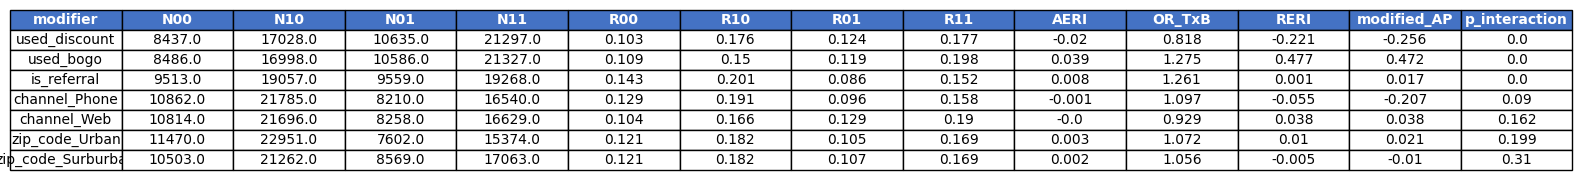

In [26]:
import matplotlib.pyplot as plt

# Convert all data to string
data = summary.astype(str).values
columns = summary.columns

fig, ax = plt.subplots(figsize=(len(columns)*1.2, 2))  # adjust height
ax.axis("off")

table = ax.table(
    cellText=data,
    colLabels=columns,
    cellLoc="center",
    loc="center"
)

# Color only column headers
for (row, col), cell in table.get_celld().items():
    if row == 0:  # column headers
        cell.set_facecolor("#4472C4")
        cell.set_text_props(color="white", weight="bold")

# Optional: adjust font size
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Save as PNG
plt.savefig("summary_no_index.png", bbox_inches="tight", dpi=300)
plt.show()
